# TrailNet Prediction
1. Import libraries
2. Get ready for trained model
3. Load testing dataset
4. Perform prediction and save result 

## 1. Import libraries

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from shutil import rmtree
from zipfile import ZipFile
import gdown
import sys
import os
import cv2

caffe_root = os.environ['CAFFE_ROOT']
project_root = os.getcwd()

import caffe

In [2]:
# display plots in this notebook
%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

## 2. Get ready for trained model

In [3]:
prototxt_url = 'https://drive.google.com/uc?id=1-kT2Vnr_TgUcQa7cz6acXW7n5GWRtFyF'
prototxt_name = 'trailnet_color_o3.prototxt'

caffemodel_url = 'https://drive.google.com/uc?id=1fWCQ5ZsY_KziwqGWeLJuUl6IlAh98dSi'
caffemodel_name = 'trailnet_3class_real_vr_mix_color.caffemodel'

if not os.path.isfile(caffemodel_name):
    print('Downloading pre-trained TrailNet model...')
    gdown.download(caffemodel_url, output=caffemodel_name, quiet=False)
if not os.path.isfile(prototxt_name):
    print('Downloading pre-trained TrailNet prototxt...')
    gdown.download(prototxt_url, output=prototxt_name, quiet=False)

print('Finished preparing the model.')             

Finished preparing the model.


## 3. Load testing dataset

In [4]:
testdata_url = 'https://drive.google.com/uc?id=13BzOECAqRJ8DPi9dpZfzlVPqE455s66Q'
testdata_name = 'BY_TKU_indoor_outdoor'

classid_url = 'https://drive.google.com/uc?id=1QrUIUSQSCSagcMgV_1RnQjQKqRhuaBFf'
classid_name = 'class_id.txt'

if not os.path.isdir('data'):
    os.mkdir('data')
    call(['chmod', '-R', '666', 'data'])
    
if not os.path.isfile(classid_name):
    gdown.download(classid_url, output=classid_name, quiet=False)
    
if not os.path.isdir('data/' + testdata_name):
    print('Downloading testing dataset...')
    gdown.download(testdata_url, output=testdata_name+'.zip', quiet=False)
    print('Unzip testing dataset...')
    zip = ZipFile(testdata_name+'.zip')
    zip.extractall('data')
    zip.close()
    call(['rm', testdata_name+'.zip'])

print('Finished preparing the testing dataset.')       

Finished preparing the testing dataset.


### 3-3. Function of  image loader

In [5]:
class Lexicon:
    def __init__(self):
        self.path = ''
        
    def set_image_lex(self,lex):
        self.image_lex = lex
        
    def set_image_gt(self,gt):
        self.gt = gt
        
    def set_image_number(self,number):
        self.image_number = number
    
    def set_image_path(self,path):
        self.image_path = path

In [6]:
def load_images_from_folder(folder, class_type, lex):
    data_list = []
    folder_path = folder + '/' + class_type
    images = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path,filename))
        if img is not None:
            imageInfo = Lexicon()
            imageInfo.set_image_path(folder_path + '/' + filename)
            imageInfo.set_image_gt(class_type)
            imageInfo.set_image_lex(lex)
            data_list.append(imageInfo)
    return data_list

In [49]:
def load_images_from_list(txtfile, class_type, lex):
    data_list = []
    files = np.loadtxt(txtfile, str, delimiter='\n')
    images = []
    for info in files:
        if(len(info.split())) != 2: continue
        file_path = info.split()[0]
        file_class = info.split()[1]
        if(file_class == str(list(lex).index(class_type))):
            imageInfo = Lexicon()
            imageInfo.set_image_path('data/' + file_path)
            imageInfo.set_image_gt(class_type)
            imageInfo.set_image_lex(lex)
            data_list.append(imageInfo)
    return data_list

### 3-4. Read testing dataset depending on output classes

In [55]:
images_folder = 'data/' + testdata_name
lex = np.loadtxt(classid_name, str, delimiter='\n')
print 'dataset folder: ', images_folder
print 'output classes: ', lex

dataList = []
image_count = 0
print 'class: data number'
for class_type in lex:
#     data = load_images_from_folder(images_folder, class_type, lex)
    data = load_images_from_list('testing_list.txt', class_type, lex)
    print class_type, ': ', len(data)
    for i in range(len(data)):
        image_count+=1
        data[i].set_image_number(image_count)
        dataList.append(data[i])
print 'total data number: ', len(dataList)

dataset folder:  data/BY_TKU_indoor_outdoor
output classes:  ['L' 'S' 'R']
class: data number
L :  333
S :  338
R :  329
total data number:  1000


## 4. Perform prediction and save result

In [56]:
caffe_mode = 'GPU' # select GPU or CPU mode
if caffe_mode == 'GPU':
    caffe.set_device(0)  # if we have multiple GPUs, pick the first one
    caffe.set_mode_gpu()
else:
    caffe.set_mode_cpu()

net = caffe.Net(prototxt_name,      # defines the structure of the model
                caffemodel_name,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)   

### 4-1. Prepare image transformer

In [57]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
#print net.blobs['data'].data.shape


mu = np.array([136.0,145.0,154.0])
transformer.set_mean('data', mu) 

transformer.set_raw_scale('data', 255)
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension

# if model_info[5] == 'bvlc':
#     model_type = 'bvlc'
#     net.blobs['data'].reshape(1,        # batch size
#                               3,         # 3-channel images
#                               227, 227)  # image size is 227x227

In [58]:
import copy

def classify(net,data,number):
    output = []
    if number == 0:
        length = len(data)
    else:
        length = number
        
    for itera in range(0,length):
        
        #set image path
        img_path = data[itera].image_path
        
        # import original image and cropped image for prediction

        image = caffe.io.load_image(img_path)            
        # do preprocession
        transformed_image = transformer.preprocess('data', image)
        
        # do mean substraction
        #transformed_image -= np.mean(transformed_image)
        
        # copy the image data into the memory allocated for the net
        net.blobs['data'].data[...] = transformed_image
    
        # perform classification
        out = copy.deepcopy(net.forward())
        output.append(out)
    
    return output

In [59]:
import itertools
import heapq

labels = lex
print labels

def pred(out,data,number):
    lex_hit = 0
    lex_non_hit = 0
    non_hit_case = []
    
    for output,datalist in itertools.izip(out,data):    
        output_prob = output['prob'][0]  # the output probability vector for the first image in the batch
        
        if number == datalist.image_number:           
            image_number = datalist.image_number
            largest_class = heapq.nlargest(3, xrange(len(output_prob)), key=output_prob.__getitem__)
            largest_prob = heapq.nlargest(3, output_prob)
            ground_truth = datalist.gt
            image = caffe.io.load_image(datalist.image_path)
            image_path = datalist.image_path
            image_prob = output_prob

        if labels[output_prob.argmax()] == datalist.gt:
            lex_hit += 1
        else:
            lex_non_hit +=1
            non_hit_case.append(datalist.image_number)
            
    
    #print 'model_name:',model_folder
    #print 'data_name:',test_folder,'\n'
    
    print 'hit:',lex_hit,' not hit:',lex_non_hit
    accuracy = lex_hit / float(lex_hit + lex_non_hit)
    print 'accuracy: ', accuracy
    print 'non_hit_case: ', non_hit_case
    
    print '\nimage number:',image_number
    print 'image path:' ,image_path, '\n'
    print '1st predicted class is:', labels[largest_class[0]] + ', predicted probability is:', largest_prob[0]
    print '2nd predicted class is:', labels[largest_class[1]] + ', predicted probability is:', largest_prob[1]
    print '3rd predicted class is:', labels[largest_class[2]] + ', predicted probability is:', largest_prob[2]  
    print 'ground truth:', ground_truth
    
    fig = plt.figure()
    plt.subplot(2,1,1)
    plt.imshow(image)
        
    #print image_prob
    plt.subplot(2,1,2)
    x = np.arange(3)
    plt.bar(x, height= image_prob)
    plt.xticks(x+.4, lex)
    plt.ylim(ymax = 1)
        
    fig.savefig('books_read.jpg')
    return accuracy

['L' 'S' 'R']


In [60]:
print "classifying......",
output = classify(net, dataList, 0)
print "done"
# print output[10]['prob'][0]

classifying...... done


hit: 687  not hit: 313
accuracy:  0.687
non_hit_case:  [1, 11, 13, 17, 23, 25, 26, 27, 28, 34, 37, 38, 40, 42, 45, 46, 48, 49, 52, 54, 55, 59, 61, 62, 64, 67, 69, 71, 72, 75, 76, 80, 82, 83, 85, 89, 90, 91, 93, 94, 97, 98, 99, 102, 103, 104, 105, 106, 107, 108, 109, 113, 115, 116, 119, 121, 123, 125, 127, 129, 130, 131, 132, 133, 134, 135, 136, 140, 142, 143, 145, 148, 149, 151, 157, 158, 159, 161, 162, 163, 170, 171, 172, 173, 176, 179, 184, 185, 187, 188, 189, 192, 197, 205, 206, 207, 208, 212, 214, 217, 219, 220, 221, 222, 226, 228, 232, 233, 234, 236, 238, 241, 251, 252, 254, 257, 258, 261, 262, 263, 265, 267, 269, 274, 277, 278, 283, 286, 287, 293, 296, 297, 298, 299, 301, 302, 304, 306, 307, 312, 315, 316, 317, 318, 319, 323, 326, 327, 329, 333, 337, 338, 345, 346, 348, 352, 353, 354, 357, 359, 360, 368, 377, 379, 380, 383, 387, 388, 389, 394, 399, 401, 402, 404, 405, 409, 414, 416, 417, 422, 424, 426, 428, 429, 431, 434, 436, 437, 439, 443, 453, 455, 456, 457, 460, 462, 463, 464

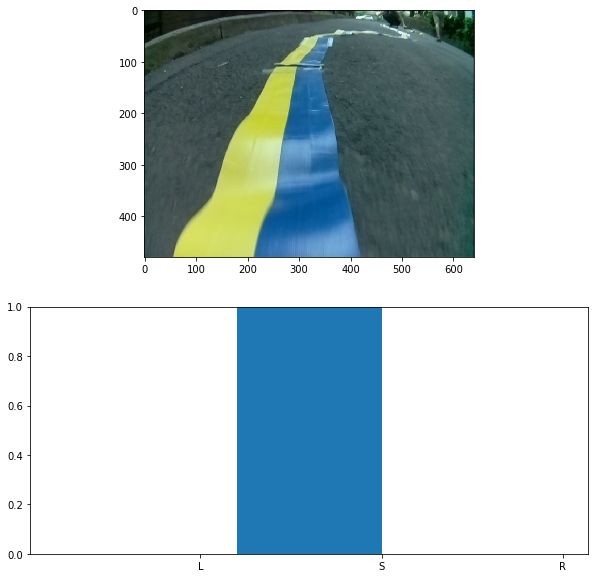

In [61]:
accuracy = pred(output, dataList, 500)

### 4-7. Save data list, prediction result, and accuracy 

In [63]:
if not os.path.isdir('testing-results'):
    os.makedirs('testing-results')
    print 'creat testing-results folder'
else:
    print 'testing-results folder exists'

import pickle

result_folder = 'testing-results/'

if not os.path.isdir(result_folder):
    os.makedirs(result_folder)
    print 'creat ' + result_folder  + 'folder'
else:
    print result_folder + ' exists'

# with open(result_folder + '/output', 'wb') as fp:
#     pickle.dump(output, fp)
# with open(result_folder + '/dataList', 'wb') as fp:
#     pickle.dump(dataList, fp)
with open(result_folder + '/accuracy.txt', "w") as text_file:
    text_file.write("Accuracy: %s" % accuracy)

testing-results folder exists
testing-results/ exists
